<font size="6"> **DMBEM Project**</font>


Lena Beber, Charles Gerike-Roberts, Elliot Regev

# Description of the Building

The building we tried to model is a two story house in England (Fig. 1). It is made out of concrete walls with a layer of insulation, has a suspended floor, a slanted roof with clay tiles and insulation and double glazed windows on every wall. 

# Hypothesis for Modelling

For our model we had to simplify the building described above. We assume that we can neglect the walls separating the rooms and even the floor inbetween the two stories, because of the equal temperature in every room. Instead we model just one large room. We also assume that all the windows of a wall can be modeled as one large window on that wall. 

# Thermal Network Model

# Equations (Matrices and Vectors)

## 

# Python Implementation

We decided to restructure the given code to make it more flexible. Our concept was two have one "main" python file that calls various functions for the different steps of the modelling. The structure of our code is depicted in the graphic below.

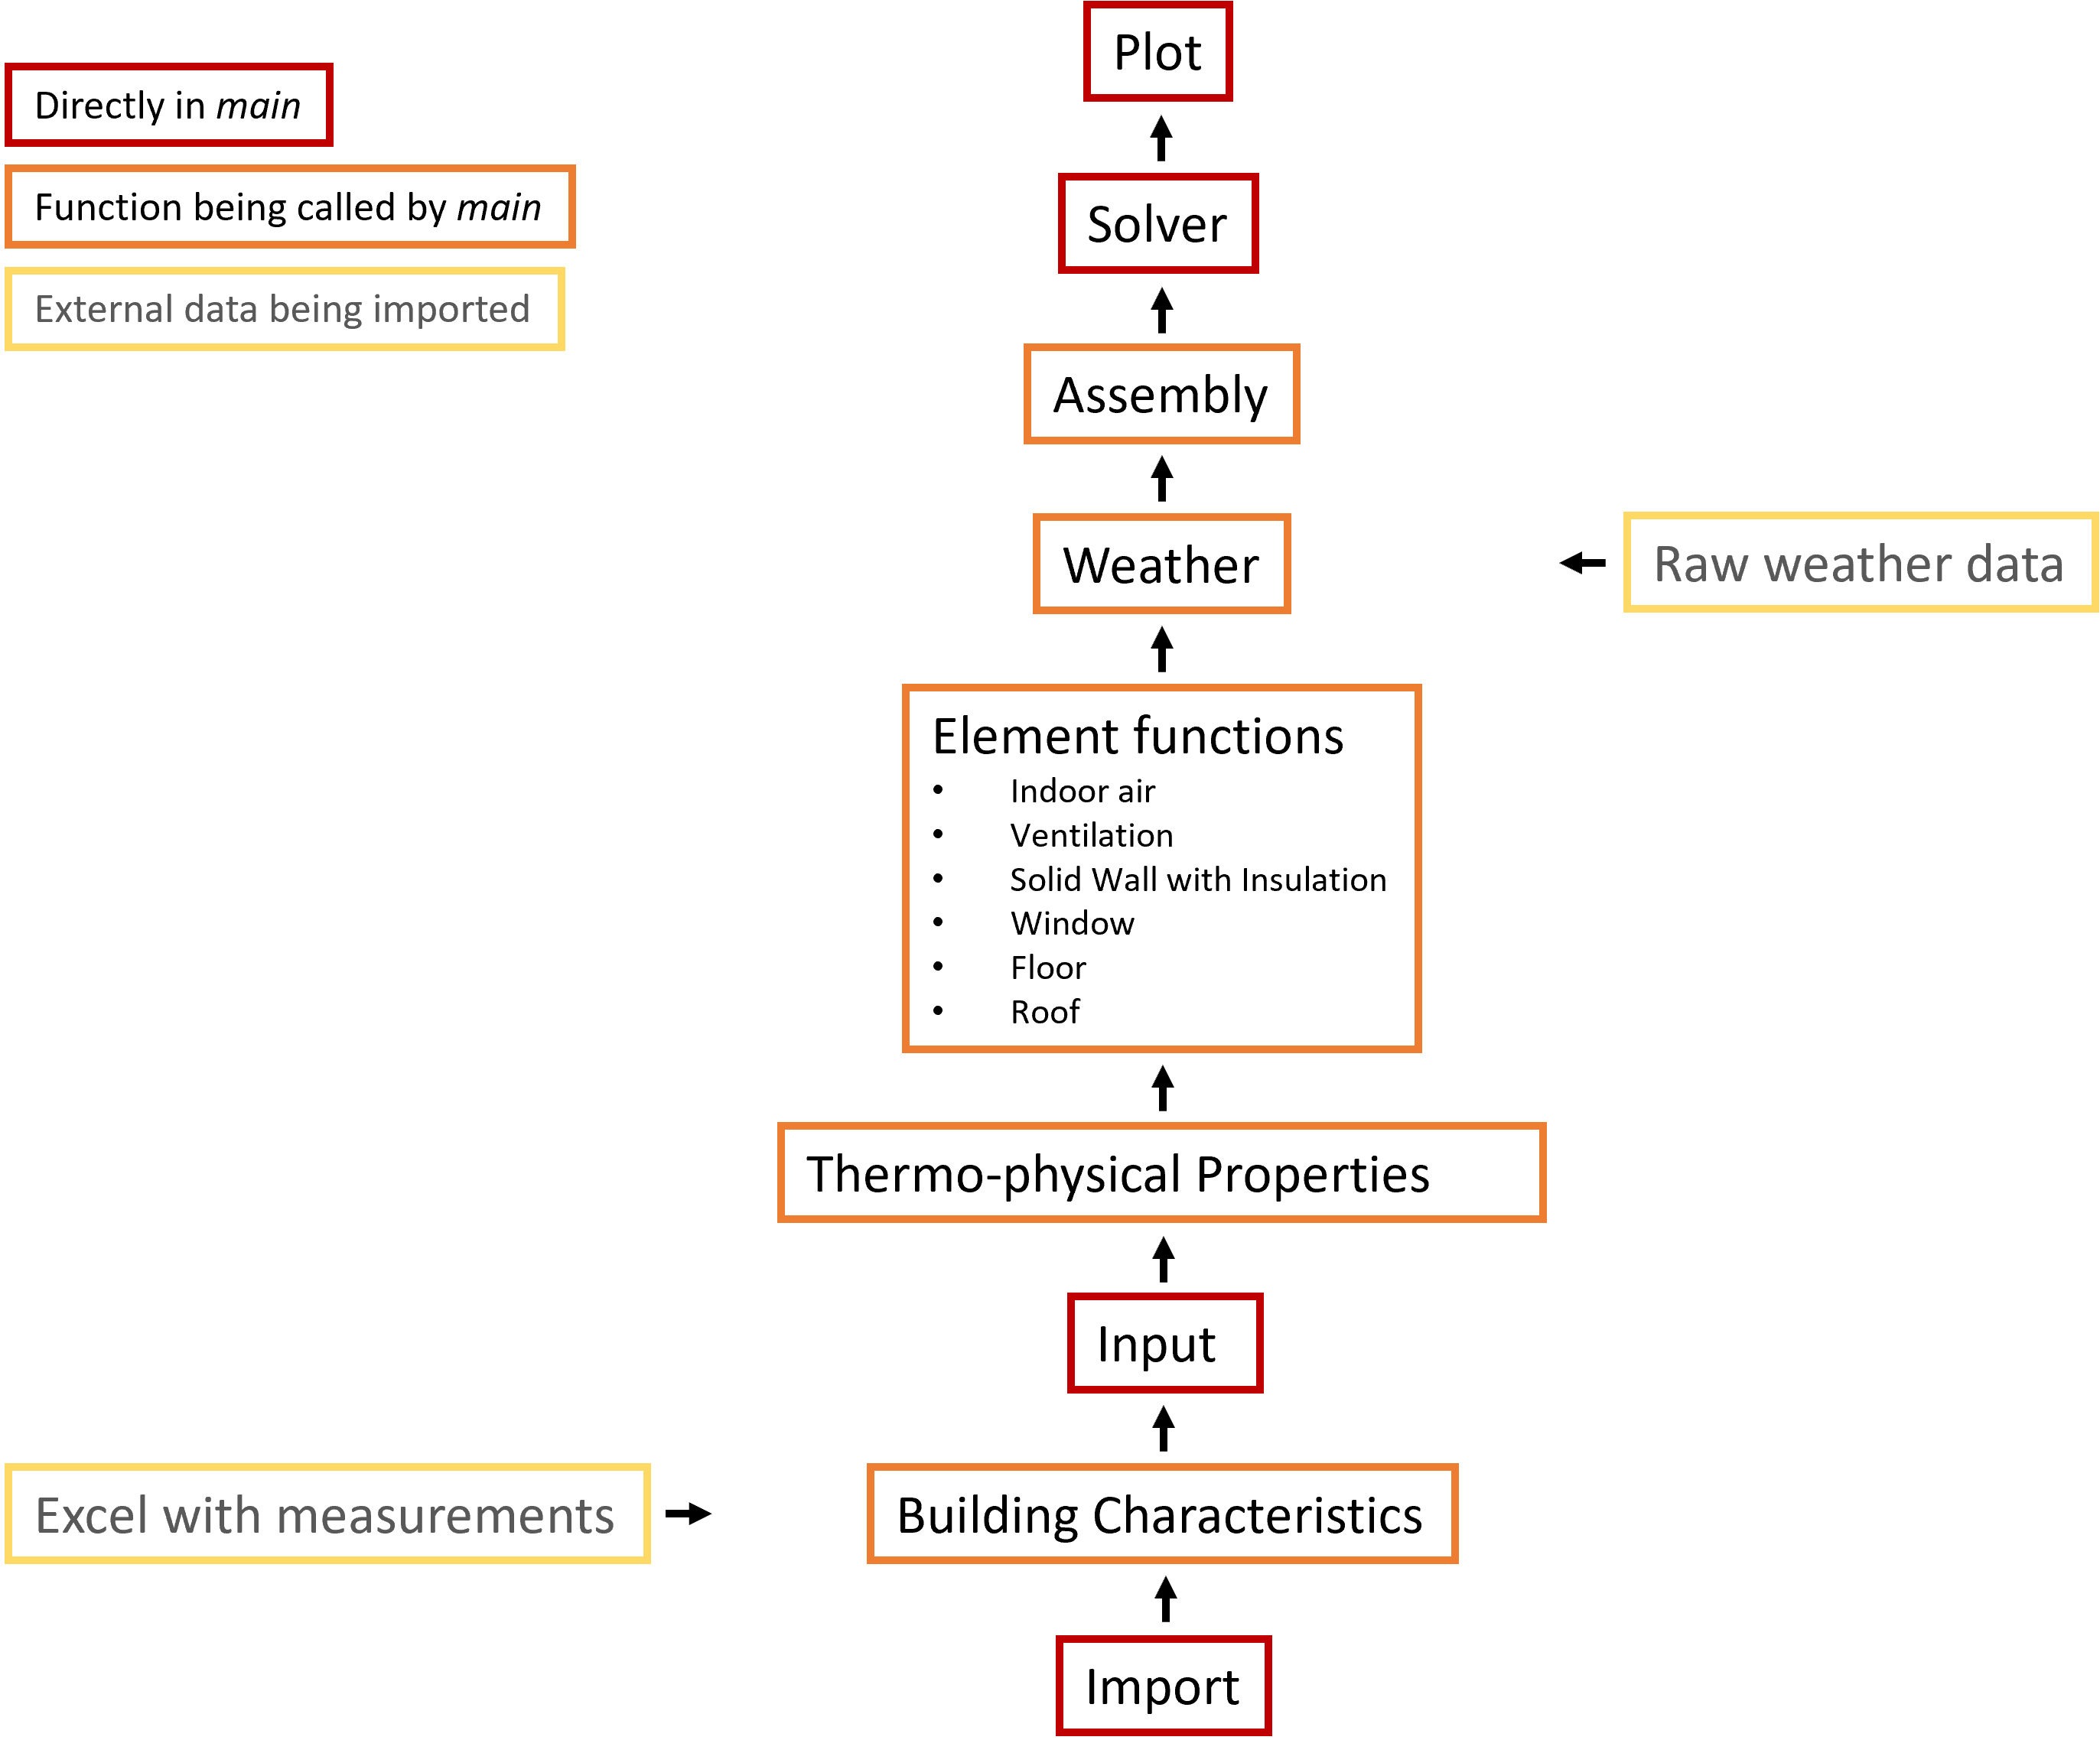

## Import
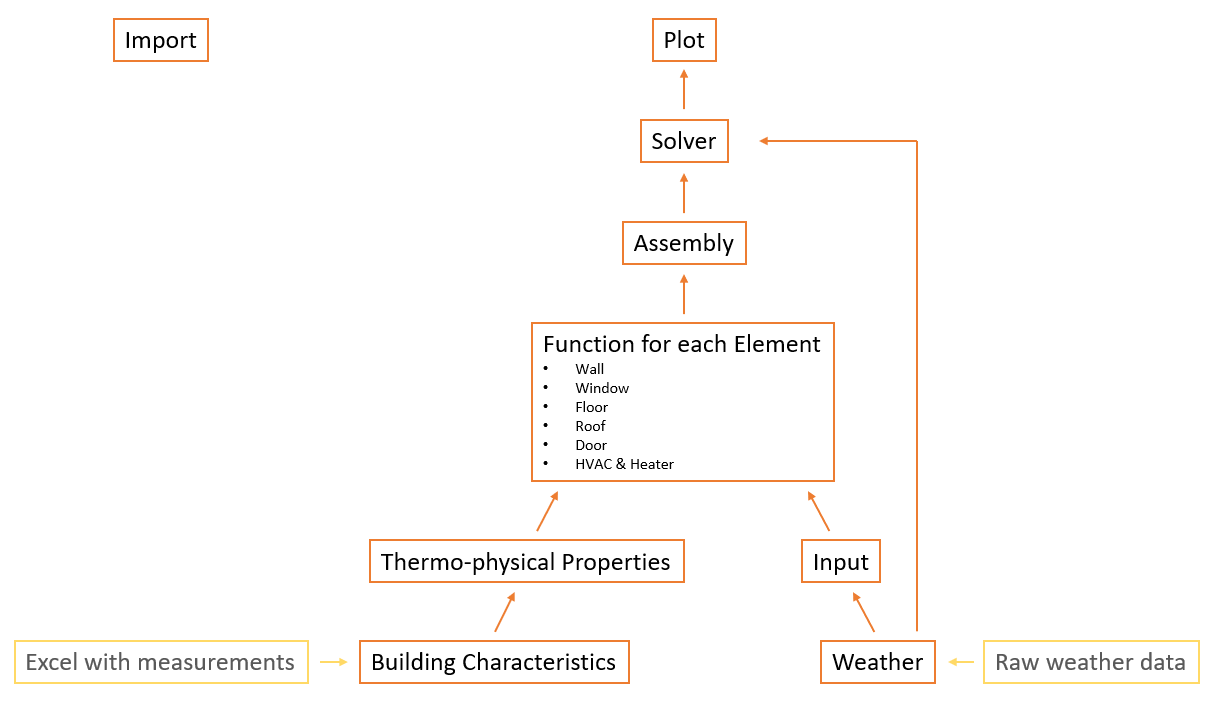

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import TCM_funcs

# global constants
σ = 5.67e-8     # W/m².K⁴ Stefan-Bolzmann constant

## Building Characteristics

This function is designed to read a csv file which contains the characteristics of the building and create a data frame from it.

In [2]:
def building_characteristics():

    bc = pd.read_csv(r'Building Characteristics.csv', na_values=["N"], keep_default_na=True)

    return bc

This function is the first to be called in the main file:

In [10]:
# Define building characteristics
bc = TCM_funcs.building_characteristics()

print(bc)

  Element_Code     Element_Type Material_1  Material_2  Material_3  Length  \
0           W1  Solid Wall w/In   Concrete  Insulation         NaN     NaN   
1           W2  Solid Wall w/In   Concrete  Insulation         NaN     3.0   
2           W3  Solid Wall w/In   Concrete  Insulation         NaN     NaN   
3           G1             SinG      Glass         NaN         NaN     3.0   
4           F1  Suspended Floor       Wood         Air         NaN     3.0   
5           R1   Flat Roof w/In       Tile  Insulation         NaN     3.0   

   Width  Height  Thickness_1  Thickness_2  Thickness_3  Surface  Volume  \
0    2.0       3          0.1          0.1          NaN        6     NaN   
1    NaN       3          0.1          0.1          NaN        9     NaN   
2    2.0       3          0.1          0.1          NaN        6     NaN   
3    NaN       3          0.1          NaN          NaN        9     NaN   
4    2.0       3          0.1          0.4          NaN        6    18.0 

As one can see, this data frame consists of different elements that can each be modelled as one thermal circuit. For every element the materials that are part of this element are specified as well as dimensions for the whole element and for the single materials.

Properties specified for each element:
- Element Code
- Element Type
- Material 1, 2 and 3
- Length
- Width
- Height
- Thickness of each Material
- Surface Area
- Volume
- Slope
- Azimuth
- Mesh for each Material



## Input 

After this changeable input variables are defined in the main file:

In [4]:
# Define Inputs
Kp = 1e4                                                                      # factor for HVAC
dt = 5                                                                        # s - time step for solver
T_set = pd.DataFrame([{'cooling': (26 + 273.15), 'heating': (22 + 273.15)}])  # K - temperature set points
Tm = 20 + 273.15                                                              # K - Mean temperature for radiative exchange
ACH = 1                                                                       # h*-1 - no. of air changes in volume per hour
h = pd.DataFrame([{'in': 4., 'out': 10}])                                     # W/m² K - convection coefficients
V = bc.Volume[4]                                                              # m³
Vdot = V * ACH / 3600                                                         # m³/s - volume flow rate due to air changes
albedo_sur = 0.2                                                              # albedo for the surroundings
latitude = 45

## Thermo-physical Properties

In this function first a data frame containing thermo-physical properties for various materials is created. As an input variable the bc data frame is given into the function and is being extended by the thermo-physical properties of the according to the specified materials per element. This extended version of the bc data frame (now called bcp, "Building Characteristics with thermo physical Properties") is being returned to the main. 

Materials currently present in the thermal properties data frame:
- concrete
- insulation
- glass
- air
- tiles
- wood

Properties listed for each of materials above:
- density kg/m³
- specific heat J/kg.K
- conductivity W/m.K
- long wave emissivity
- short wave transmittance
- absorptivity
- albedo

The values for these properties were taken from Incropera et al. (2011) Fundamentals of heat and mass transfer, 7 ed, Table A3, and the Engineering Toolbox (https://www.engineeringtoolbox.com, 30. October 2021).


In [5]:
def thphprop(BCdf):
    thphp = {'Material': ['Concrete', 'Insulation', 'Glass', 'Air', 'Tile', 'Wood'],
             'Density': [2300, 55, 2500, 1.2, None, 720],            # kg/m³
             'Specific_Heat': [880, 1210, 750, 1000, None, 1255],    # J/kg.K
             'Conductivity': [1.4, 0.027, 1.4, None, 0.52, 0.16],    # W/m.K
             'LW_Emissivity': [0.9, 0, 0.9, 0, 0.91, 0.885],
             'SW_Transmittance': [0, 0, 0.83, 1, 0, 0],
             'SW_Absorptivity': [0.25, 0.25, 0.1, 0, 0.64, 0.6],
             'Albedo': [0.75, 0.75, 0.07, 0, 0.36, 0.4]}             # albedo + SW transmission + SW absorptivity = 1

    thphp = pd.DataFrame(thphp)
    print('Table of collected thermo-physical properties:')
    print(thphp)

    # add empty columns for thermo-physical properties
    BCdf = BCdf.reindex(columns=BCdf.columns.to_list() + ['density_1', 'specific_heat_1', 'conductivity_1',
                                                          'LW_emissivity_1', 'SW_transmittance_1', 'SW_absorptivity_1',
                                                          'albedo_1', 'density_2', 'specific_heat_2', 'conductivity_2',
                                                          'LW_emissivity_2', 'SW_transmittance_2', 'SW_absorptivity_2',
                                                          'albedo_2', 'density_3', 'specific_heat_3', 'conductivity_3',
                                                          'LW_emissivity_3', 'SW_transmittance_3', 'SW_absorptivity_3',
                                                          'albedo_3'])

    # fill columns with properties for the given materials 1-3 of each element
    for i in range(0, len(BCdf['Material_1'])):
        for j in range(0, len(thphp['Material'])):
            if BCdf.loc[i, 'Material_1'] == thphp.Material[j]:
                BCdf.loc[i, 'density_1'] = thphp.Density[j]
                BCdf.loc[i, 'specific_heat_1'] = thphp.Specific_Heat[j]
                BCdf.loc[i, 'conductivity_1'] = thphp.Conductivity[j]
                BCdf.loc[i, 'LW_emissivity_1'] = thphp.LW_Emissivity[j]
                BCdf.loc[i, 'SW_transmittance_1'] = thphp.SW_Transmittance[j]
                BCdf.loc[i, 'SW_absorptivity_1'] = thphp.SW_Absorptivity[j]
                BCdf.loc[i, 'albedo_1'] = thphp.Albedo[j]

    for i in range(0, len(BCdf['Material_2'])):
        for j in range(0, len(thphp['Material'])):
            if BCdf.loc[i,'Material_2'] == thphp.Material[j]:
                BCdf.loc[i,'density_2'] = thphp.Density[j]
                BCdf.loc[i,'specific_heat_2'] = thphp.Specific_Heat[j]
                BCdf.loc[i,'conductivity_2'] = thphp.Conductivity[j]
                BCdf.loc[i,'LW_emissivity_2'] = thphp.LW_Emissivity[j]
                BCdf.loc[i,'SW_transmittance_2'] = thphp.SW_Transmittance[j]
                BCdf.loc[i,'SW_absorptivity_2'] = thphp.SW_Absorptivity[j]
                BCdf.loc[i,'albedo_2'] = thphp.Albedo[j]

    for i in range(0, len(BCdf['Material_3'])):
        for j in range(0, len(thphp['Material'])):
            if BCdf.loc[i,'Material_3'] == thphp.Material[j]:
                BCdf.loc[i,'density_3'] = thphp.Density[j]
                BCdf.loc[i,'specific_heat_3'] = thphp.Specific_Heat[j]
                BCdf.loc[i,'conductivity_3'] = thphp.Conductivity[j]
                BCdf.loc[i,'LW_emissivity_3'] = thphp.LW_Emissivity[j]
                BCdf.loc[i,'SW_transmittance_3'] = thphp.SW_Transmittance[j]
                BCdf.loc[i,'SW_absorptivity_3'] = thphp.SW_Absorptivity[j]
                BCdf.loc[i,'albedo_3'] = thphp.Albedo[j]

    return BCdf

This function is second to be called in the main:

In [9]:
bcp = TCM_funcs.thphprop(bc)

## Element Functions

As a next step the Matrices for every single element are being created and stored in a data frame. As of now there are functions for six different elements:

- Indoor Air
- Ventilation (HVAC)
- Solid Wall with Insulation
- Window (single glazing)
- Floor
- Roof (flat)

Depending on the element there are diffierent variables needed to create the matrices, so the input for every element function is a different one. The input is described in the beginning of each function. All of the element functions return a dictionary containing the matrices describing that element.

In [7]:
def indoor_air(bcp_sur, h, V):
    """
    Input:
    bcp_sur, surface column of bcp dataframe
    h, convection dataframe
    V, Volume of the room (from bcp)
    Output: TCd, a dictionary of the all the matrices of the thermal circuit of the inside air
    """
    nt = len(bcp_sur) + 1
    nq = len(bcp_sur)

    nq_ones = np.ones(nq)
    A = np.diag(-nq_ones)
    A = np.c_[nq_ones, A]

    G = np.zeros(nq)
    for i in range(0, len(G)):
        G[i] = h['in'] * bcp_sur[i]
    G = np.diag(G)
    b = np.zeros(nq)
    C = np.zeros(nt)
    C[-1] = (1.2 * 1000 * V) / 2  # Capacity air = Density*specific heat*V
    C = np.diag(C)
    f = np.zeros(nt)
    f[-1] = 1
    y = np.zeros(nt)
    y[-1] = 1
    TCd = {'A': A, 'G': G, 'b': b, 'C': C, 'f': f, 'y': y}

    return TCd


def ventilation(V, V_dot, Kp):
    """
    Input:
    V, Volume of the room (from bcp)
    V_dot
    Kp
    Output:
    TCd, a dictionary of the all the matrices describing the thermal circuit of the ventilation
    """
    Gv = V_dot * 1.2 * 1000  # Va_dot * air['Density'] * air['Specific heat']
    A = np.array([[1],
                  [1]])
    G = np.diag(np.hstack([Gv, Kp]))
    b = np.array([1, 1])
    C = np.array((1.2 * 1000 * V) / 2)
    f = 1
    y = 1

    TCd = {'A': A, 'G': G, 'b': b, 'C': C, 'f': f, 'y': y}

    return TCd


def solid_wall_w_ins(bcp_r, h):
    """Input:
    bcp_r, one row of the bcp dataframe
    h, convection dataframe
    Output: TCd, a dictionary of the all the matrices of one thermal circuit describing a solid wall with insulation
    """
    # Thermal conductances
    # Conduction
    G_cd_cm = bcp_r['conductivity_1'] / bcp_r['Thickness_1'] * bcp_r['Surface']  # concrete
    G_cd_in = bcp_r['conductivity_2'] / bcp_r['Thickness_2'] * bcp_r['Surface']  # insulation

    # Convection
    Gw = h * bcp_r['Surface']  # wall

    # Thermal capacities
    Capacity_cm = bcp_r['density_1'] * bcp_r['specific_heat_1'] * bcp_r['Surface'] * bcp_r['Thickness_1']
    Capacity_in = bcp_r['density_2'] * bcp_r['specific_heat_2'] * bcp_r['Surface'] * bcp_r['Thickness_2']

    # Thermal network
    # ---------------
    nq = 1 + 2 * (int(bcp_r['Mesh_1']) + int(bcp_r['Mesh_2']))
    nt = 1 + 2 * (int(bcp_r['Mesh_1']) + int(bcp_r['Mesh_2']))

    A = np.eye(nq + 1, nt)
    A = -np.diff(A, 1, 0).T

    nc = int(bcp_r['Mesh_1'])
    ni = int(bcp_r['Mesh_2'])
    Gcm = 2 * nc * G_cd_cm
    Gcm = 2 * nc * np.array(Gcm)
    Gim = 2 * ni * G_cd_in
    Gim = 2 * ni * np.array(Gim)
    G = np.diag(np.hstack([Gw['out'], Gcm, Gim]))

    b = np.zeros(nq)
    b[0] = 1

    Ccm = Capacity_cm / nc * np.mod(range(0, 2 * nc), 2)
    Cim = Capacity_in / ni * np.mod(range(0, 2 * ni), 2)
    C = np.diag(np.hstack([Ccm, Cim, 0]))

    f = np.zeros(nt)
    f[0] = f[-1] = 1

    y = np.zeros(nt)

    TCd = {'A': A, 'G': G, 'b': b, 'C': C, 'f': f, 'y': y}

    return TCd


def window(bcp_r, h):
    """Input:
    bcp_r, one row of the bcp dataframe
    h, convection dataframe
    Output: TCd, a dictionary of the all the matrices of one thermal circuit describing a solid wall with insulation
    """
    A = np.array([[1, 0],
                  [-1, 1]])
    Ggo = h['out'] * bcp_r['Surface']
    Ggs = 1 / (1 / Ggo + 1 / (2 * bcp_r['conductivity_1']))
    G = np.diag(np.hstack([Ggs, 2 * bcp_r['conductivity_1']]))
    b = np.array([1, 0])
    C = np.diag([bcp_r['density_1'] * bcp_r['specific_heat_1'] * bcp_r['Surface'] * bcp_r['Thickness_1'], 0])
    f = np.array([1, 0])
    y = np.array([0, 0])
    TCd = {'A': A, 'G': G, 'b': b, 'C': C, 'f': f, 'y': y}

    return TCd


def susp_floor(bcp_r, h, V):
    """Input:
    bcp_r, one row of the bcp dataframe
    h, convection dataframe
    V, Volume of the room from bcp
    Output: TCd, a dictionary of the all the matrices of one thermal circuit describing a suspended floor
    """
    A = np.array([[1, 0, 0, 0],
                  [-1, 1, 0, 0],
                  [0, -1, 1, 0],
                  [0, 0, -1, 1]])
    Gw = h * bcp_r['Surface']
    G_cd = bcp_r['conductivity_1'] / bcp_r['Thickness_1'] * bcp_r['Surface']  # wood
    G = np.diag(np.hstack(
        [Gw['in'], Gw['in'], G_cd, G_cd]))
    b = np.array([1, 0, 0, 0])
    Capacity_w = bcp_r['density_1'] * bcp_r['specific_heat_1'] * bcp_r['Surface'] * bcp_r['Thickness_1']  # wood
    Capacity_a = bcp_r['density_2'] * bcp_r['specific_heat_2'] * V  # air
    C = np.diag([Capacity_a, 0, Capacity_w, 0])
    f = np.array([0, 0, 0, 1])
    y = np.array([0, 0, 0, 0])

    TCd = {'A': A, 'G': G, 'b': b, 'C': C, 'f': f, 'y': y}

    return TCd


def flat_roof_w_in(bcp_r, h):
    """Input:
    bcp_r, one row of the bcp dataframe
    h, convection dataframe
    Output: TCd, a dictionary of the all the matrices of one thermal circuit describing a flat roof with insulation
    """
    A = np.array([[-1, 0, 0],
                   [-1, 1, 0],
                   [0, -1, 1]])
    Gw = h * bcp_r['Surface']
    G_cd_in = bcp_r['conductivity_2'] / bcp_r['Thickness_2'] * bcp_r['Surface']  # insulation
    ni = int(bcp_r['Mesh_2'])
    Gim = 2 * ni * G_cd_in
    Gim = 2 * ni * np.array(Gim)
    G = np.diag(np.hstack([Gw['out'], Gim]))
    b = np.array([1, 0, 0])
    Capacity_i = bcp_r['density_2'] * bcp_r['specific_heat_2'] * bcp_r['Surface'] * bcp_r['Thickness_2']  # insulation
    C = np.diag([0, Capacity_i, 0])
    f = np.array([1, 0, 1])
    y = np.array([0, 0, 0])

    TCd = {'A': A, 'G': G, 'b': b, 'C': C, 'f': f, 'y': y}

    return TCd


The dictionaries returned by these functions are stored in yet another ditcionary for all thermal circuits, later to be turned into a data frame. After creating an empty dictionary in the main it is filled with the dict.update function in which the element functions are called. As the thermal circuits of the indoor air and the ventilation are present in every model we decided they sould always be thermal circuit 0 and 1 in the overall TCd data frame. This is why they are called first in the main. The remaining element functions are called via a for-loop going through the rows of the bcp data frame. With the help of if-statements it is determined which element function is to be called.

In [8]:
# Thermal Circuits
TCd = {}
TCd.update({str(0): TCM_funcs.indoor_air(bcp.Surface, h, V)})  # inside air
TCd.update({str(1): TCM_funcs.ventilation(V, Vdot, Kp)})  # ventilation and heating
for i in range(0, len(bcp)):
    if bcp.Element_Type[i] == 'Solid Wall w/In':
        TCd.update({str(i+2): TCM_funcs.solid_wall_w_ins(bcp.loc[i, :], h)})
    elif bcp.Element_Type[i] == 'SinG':
        TCd.update({str(i+2): TCM_funcs.window(bcp.loc[i, :], h)})
    elif bcp.Element_Type[i] == 'Suspended Floor':
        TCd.update({str(i+2): TCM_funcs.susp_floor(bcp.loc[i, :], h, V)})
    elif bcp.Element_Type[i] == 'Flat Roof 1/In':
        TCd.update({str(i+2): TCM_funcs.flat_roof_w_in(bcp.loc[i, :], h)})

TCd = pd.DataFrame(TCd)


## Weather

## Assembly


## Solver



## Plot


# Discissuon of Results

# Conclusions